## Population and Congressional Apportionment Projections


### Project Scope

This project analyzes data from the United States Census Bureau from 2010 through 2017 to:
<ul>
    <li>Forecast population changes per state</li>
    <li>Predict which state will gain, lose, or maintain congressional seats using the apportionment formula implemented in the early 1900s</li>
    <li>Explore the shift in congressional seat assignment if the District of Columbia and Puerto Rico were to achieve statehood prior to the 2020 census</li>
    <li>Conduct preliminary EDA on domestic migration between states and its correlation to the Economic Freedom Index and median housing prices by state </li>
    <li>Begin exploration of congressional partisan breakdowns and more advanced demographic analysis (gender, age/generation) to identify partisan lean and areas of opportunity for party leaders/politicians</li>
</ul>

The ultimate goal is to provide meaningful projections on population and congressional representative shifts in support of fair democratic processes and redistricting efforts on federal and state levels. The outcomes of these projections are intended to provide information to a variety of groups including politicians, party leaders/organizations (Democratic National Committee, Republican National Committee), state and federal legislators, and even the average citizen who wants to better understand the outcome and impact of a decennial census.

In [17]:
## Modules needed for project
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import math, datetime
from sklearn import preprocessing, svm

## Preproccessing helps with scaling data  
## cross_validation helps with training and testing data  
## svm support vector machines

from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.model_selection import train_test_split, cross_validate
import seaborn as sns
from scipy import stats
from pprint import pprint

style.use('ggplot')

#### Data Preprocessing

Population and demographics data sets from the United States Census are used for this project. Preliminary data preprocessing was required to import the data and establish baseline calculations like gross and relative population change.

In [5]:
### load relevant columns of population data from 2010 through 2017 into a pandas dataframe and renamed columns for clarity

demo_data = pd.read_csv("./data/PEP_2017_PEPANNRES_with_ann.csv", usecols = ['Geography','Population Estimate (as of July 1) - 2010','Population Estimate (as of July 1) - 2011',
          'Population Estimate (as of July 1) - 2012','Population Estimate (as of July 1) - 2013','Population Estimate (as of July 1) - 2014',
          'Population Estimate (as of July 1) - 2015','Population Estimate (as of July 1) - 2016','Population Estimate (as of July 1) - 2017'])

demo_data = demo_data.rename(columns = {'Geography': 'State','Population Estimate (as of July 1) - 2010':'2010','Population Estimate (as of July 1) - 2011':'2011',
                                          'Population Estimate (as of July 1) - 2012':'2012','Population Estimate (as of July 1) - 2013':'2013','Population Estimate (as of July 1) - 2014':'2014',
                                        'Population Estimate (as of July 1) - 2015':'2015','Population Estimate (as of July 1) - 2016':'2016','Population Estimate (as of July 1) - 2017':'2017'})


demo_data.head()

,State,2010,2011,2012,2013,2014,2015,2016,2017
0,Alabama,4785579,4798649,4813946,4827660,4840037,4850858,4860545,4874747
1,Alaska,714015,722259,730825,736760,736759,737979,741522,739795
2,Arizona,6407002,6465488,6544211,6616124,6706435,6802262,6908642,7016270
3,Arkansas,2921737,2938640,2949208,2956780,2964800,2975626,2988231,3004279
4,California,37327690,37672654,38019006,38347383,38701278,39032444,39296476,39536653


<font color="blue">In order to analyze the data more equally, year-to-year percent changes were calculated and placed in a separate dataframe, **pctchange_demo**.</font>

In [6]:
### Getting the % change for every year.   --- Line chart

demo_data['2011 %'] = (demo_data['2011'] - demo_data['2010']) / demo_data['2010'] * 100.0
demo_data['2012 %'] = (demo_data['2012'] - demo_data['2011']) / demo_data['2011'] * 100.0
demo_data['2013 %'] = (demo_data['2013'] - demo_data['2012']) / demo_data['2012'] * 100.0
demo_data['2014 %'] = (demo_data['2014'] - demo_data['2013']) / demo_data['2013'] * 100.0
demo_data['2015 %'] = (demo_data['2015'] - demo_data['2014']) / demo_data['2014'] * 100.0
demo_data['2016 %'] = (demo_data['2016'] - demo_data['2015']) / demo_data['2015'] * 100.0
demo_data['2017 %'] = (demo_data['2017'] - demo_data['2016']) / demo_data['2016'] * 100.0


In [7]:
### Limiting to % change only
pctchange_demo =  demo_data[['State','2011 %','2012 %','2013 %','2014 %','2015 %','2016 %','2017 %']]
pctchange_demo.head()

,State,2011 %,2012 %,2013 %,2014 %,2015 %,2016 %,2017 %
0,Alabama,0.273112,0.318777,0.284881,0.256377,0.223573,0.199697,0.292189
1,Alaska,1.154598,1.186001,0.812096,-0.000136,0.165590,0.480095,-0.232899
2,Arizona,0.912845,1.217588,1.098880,1.365014,1.428881,1.563892,1.557875
3,Arkansas,0.578526,0.359622,0.256747,0.271241,0.365151,0.423608,0.537040
4,California,0.924150,0.919372,0.863718,0.922866,0.855698,0.676442,0.611192


In order to gain a better understanding of population trends, a subset of six states were selected and graphed.

In [8]:
geo_list = ['California', 'Illinois', 'New York', 'Texas', 'Utah', 'West Virginia']

states_pct = pctchange_demo.loc[pctchange_demo['State'].isin(geo_list)]

## Dataframe is transposed so percent changes each year are the rows while the states become the columns
states_pct1 = states_pct.transpose()
states_pct1 = states_pct1.reset_index()
states_pct1 = states_pct1.rename(columns={'index': 'Year Change', 4: 'California', 13: 'Illinois',
                          43: 'Texas', 48: 'West Virginia',44:'Utah',32: 'New York'})
states_pct1 = states_pct1[1:]
states_pct1.head()

,Year Change,California,Illinois,New York,Texas,Utah,West Virginia
1,2011 %,0.92415,0.16433,0.624508,1.59568,1.44743,0.0310627
2,2012 %,0.919372,0.125918,0.507196,1.692,1.37784,0.0252845
3,2013 %,0.863718,0.092472,0.443838,1.53749,1.6025,-0.163149
4,2014 %,0.922866,-0.0617902,0.309783,1.79445,1.33485,-0.25422
5,2015 %,0.855698,-0.158254,0.231455,1.85663,1.5737,-0.425249


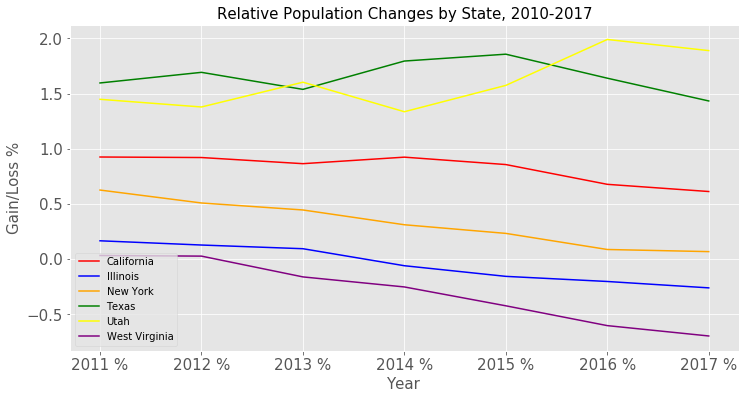

In [9]:
line_fig = plt.figure(figsize =(12,6))
n = plt.plot(states_pct1["Year Change"],states_pct1["California"],color = "red")
y = plt.plot(states_pct1["Year Change"],states_pct1["Illinois"],color = "blue")
n = plt.plot(states_pct1["Year Change"],states_pct1["New York"],color = "orange")
z = plt.plot(states_pct1["Year Change"],states_pct1["Texas"],color = "green")
t = plt.plot(states_pct1["Year Change"],states_pct1["Utah"],color = "yellow")
o = plt.plot(states_pct1["Year Change"],states_pct1["West Virginia"],color = "purple")


## Set the tick and label fontsize
plt.tick_params(labelsize = 15)

## Set the title
_ = plt.title("Relative Population Changes by State, 2010-2017", fontsize = 15)

## Set the y-label
_ = plt.ylabel("Gain/Loss %", fontsize = 15)

## Set the x-label
_ = plt.xlabel("Year", fontsize = 15)
plt.legend()
plt.show()


Additionally, the gross state population changes were calculated between 2010 and 2017.

In [10]:
## calculate gross population change between 2010 and 2017

demo_dat_pop_add = demo_data
demo_dat_pop_add['Total Population Change'] = demo_dat_pop_add['2017'] - demo_dat_pop_add['2010']
demo_dat_pop_add = demo_dat_pop_add.loc[demo_dat_pop_add['State'].isin(geo_list)]
total_pop_change = demo_dat_pop_add[['State','Total Population Change']]
total_pop_change = total_pop_change.transpose()
total_pop_change = total_pop_change.reset_index()
gross_pop_change = total_pop_change.rename(columns={'index': 'Total Population Change', 4: 'California', 13: 'Illinois',
                          43: 'Texas', 48: 'West Virginia', 44: 'Utah', 32: 'New York'})
gross_pop_change = gross_pop_change[1:]
gross_pop_change = gross_pop_change[['California','Illinois','New York','Texas','Utah','West Virginia']]
gross_pop_change.head()

,California,Illinois,New York,Texas,Utah,West Virginia
1,2208963,-39173,444214,3062948,326573,-38458


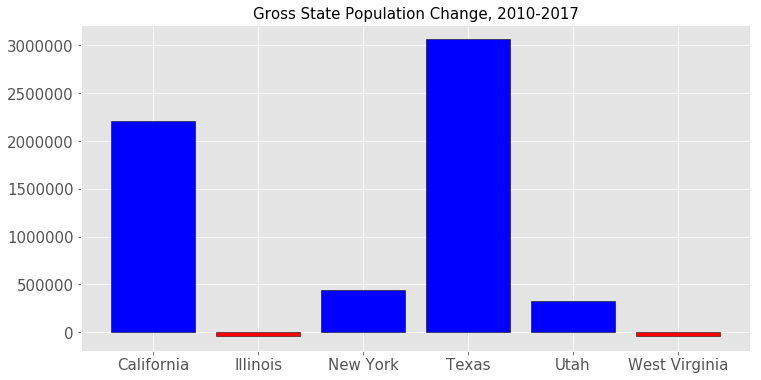

In [11]:
bar_fig = plt.figure(figsize = (12, 6))
        
_  = plt.bar(
    geo_list,    
    gross_pop_change.values[0],
    tick_label = geo_list,
    color = ['blue', 'red', 'blue', 'blue', 'blue', 'red'],
    edgecolor = "black"

)
plt.tick_params(labelsize = 15)
_ = plt.title("Gross State Population Change, 2010-2017", fontsize = 15)

In comparing the rates of change shown in the line graph, Relative Population Changes by State, 2010-2017, to the bar chart depicting gross population changes from 2010 to 2017, it should be noted that the rates of population growth for all states but Utah have been slowing since 2010. However, only Illinois and West Virginia have actually crossed the thresholds for slow or no growth to actual population loss from 2010 to 2017.

### Linear Regression Model

Linear regression was used to predict the population values for the country for the 2018, 2019, and 2020 years. The original population data were reloaded as a model training data set as a first step. Three functions were created to support the linear regression calculation:
<ol>
    <li>`linear_model` which calculates the population change for each subsequent year using a standard `mx+b` linear model</li>
    <li>`train_df_load` which is modifies the data frame to append additional columns at the end while calling `linear_model` for the value calculations</li>
    <li>`train_mod` which is a central function to easily run the two functions above</li>
</ol>

#### Population by State

In [12]:
## Creation of model training data set using only relevant columns from data set

demo_train = pd.read_csv("./data/PEP_2017_PEPANNRES_with_ann.csv", usecols = ['Geography','Population Estimate (as of July 1) - 2010','Population Estimate (as of July 1) - 2011',
          'Population Estimate (as of July 1) - 2012','Population Estimate (as of July 1) - 2013','Population Estimate (as of July 1) - 2014',
          'Population Estimate (as of July 1) - 2015','Population Estimate (as of July 1) - 2016','Population Estimate (as of July 1) - 2017'])

demo_train = demo_train.rename(columns = {'Geography': 'State','Population Estimate (as of July 1) - 2010':'2010','Population Estimate (as of July 1) - 2011':'2011',
                                          'Population Estimate (as of July 1) - 2012':'2012','Population Estimate (as of July 1) - 2013':'2013','Population Estimate (as of July 1) - 2014':'2014',
                                        'Population Estimate (as of July 1) - 2015':'2015','Population Estimate (as of July 1) - 2016':'2016','Population Estimate (as of July 1) - 2017':'2017'})

demo_train.head(10)

,State,2010,2011,2012,2013,2014,2015,2016,2017
0,Alabama,4785579,4798649,4813946,4827660,4840037,4850858,4860545,4874747
1,Alaska,714015,722259,730825,736760,736759,737979,741522,739795
2,Arizona,6407002,6465488,6544211,6616124,6706435,6802262,6908642,7016270
3,Arkansas,2921737,2938640,2949208,2956780,2964800,2975626,2988231,3004279
4,California,37327690,37672654,38019006,38347383,38701278,39032444,39296476,39536653
5,Colorado,5048029,5116411,5186330,5262556,5342311,5440445,5530105,5607154
6,Connecticut,3580171,3591927,3597705,3602470,3600188,3593862,3587685,3588184
7,Delaware,899712,907884,916868,925114,934805,944107,952698,961939
8,District of Columbia,605040,620336,635630,650114,660797,672736,684336,693972
9,Florida,18846461,19097369,19341327,19584927,19897747,20268567,20656589,20984400


In [13]:
def linear_model(x, y):
    x_bar, y_bar = np.mean(x), np.mean(y)
    m = sum((x - x_bar)*(y - y_bar))/sum((x - x_bar)**2)
    b = y_bar - m * x_bar
    return (m, b) ## making an array

In [14]:
def train_mod(train_mod_df, year_end): 
    import math
    j = train_mod_df.columns.values[-1]
    j = int(j)

    while j < year_end:
        j = j + 1
        new_train_df = train_df_load(train_mod_df, j)
       

    return(new_train_df)

In [15]:
def train_df_load(train_df, j_num):
    for i, row in train_df.iterrows():
       #### print(row)
        population = np.array(row[1:])
        years = list(train_df.columns.values)
        years.pop(0) ## removing the name
        if len(years)> len(population):   ## for each pass
            years.pop(-1)
        years = [int(k) for k in years] ## making them ints
        years = np.array(years) ## creating a years array
        years_train, years_test, pop_train, pop_test = train_test_split(years,population,test_size=1)
        gain, b = linear_model(np.array(years_train), np.array(pop_train))
        next_year = (row[-1]+gain) ### Projected Gain + last year
        next_year = int(round(next_year))
        next_year = math.trunc(next_year)
        year_ar = str(j_num)
        train_df.loc[i,year_ar] = next_year        
    return(train_df)

#### Population Data by State with 2018 - 2020 Projections

In [18]:
demo_model = train_mod(demo_train, 2020)
demo_model.head()

,State,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Alabama,4785579,4798649,4813946,4827660,4840037,4850858,4860545,4874747,4887440.0,4900028.0,4912564.0
1,Alaska,714015,722259,730825,736760,736759,737979,741522,739795,743505.0,746967.0,749429.0
2,Arizona,6407002,6465488,6544211,6616124,6706435,6802262,6908642,7016270,7103994.0,7193249.0,7283490.0
3,Arkansas,2921737,2938640,2949208,2956780,2964800,2975626,2988231,3004279,3015427.0,3026397.0,3037790.0
4,California,37327690,37672654,38019006,38347383,38701278,39032444,39296476,39536653,39869089.0,40180300.0,40493766.0


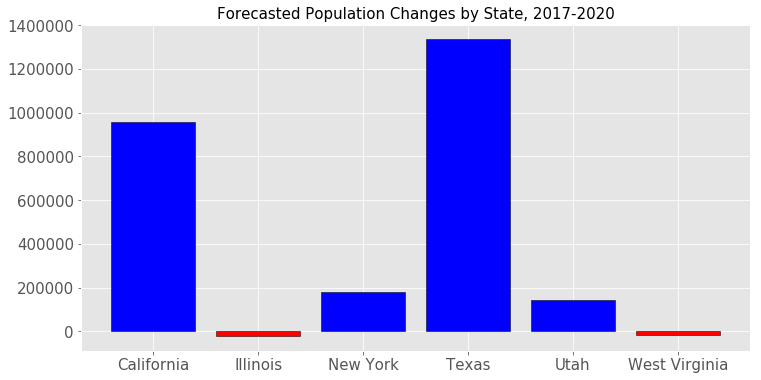

In [19]:
### Displaying forecasted changes:

demo_dat_pop_add = demo_model
demo_dat_pop_add['Total Population Change'] = demo_dat_pop_add['2020'] - demo_dat_pop_add['2017']
demo_dat_pop_add = demo_dat_pop_add.loc[demo_dat_pop_add['State'].isin(geo_list)]
total_pop_change = demo_dat_pop_add[['State','Total Population Change']]
total_pop_change = total_pop_change.transpose()
total_pop_change = total_pop_change.reset_index()
total_pop_change.head()
states_total_proj = total_pop_change.rename(columns={'index': 'Total Population Change', 4: 'California', 1: 'Northeast', 13: 'Illinois',
                          43: 'Texas', 48: 'West Virginia',44:'Utah',32: 'New York'})

states_total_proj = states_total_proj[1:]
states_total_proj = states_total_proj[['California','Illinois','New York','Texas','Utah','West Virginia']]
states_total_proj.head()

bar_fig = plt.figure(figsize = (12, 6))
        
_  = plt.bar(
    geo_list,
    states_total_proj.values[0],
    color = ("blue","red","blue","blue","blue","red"),
    edgecolor = "black",
    tick_label = geo_list)
plt.tick_params(labelsize = 15)
_ = plt.title("Forecasted Population Changes by State, 2017-2020", fontsize = 15)

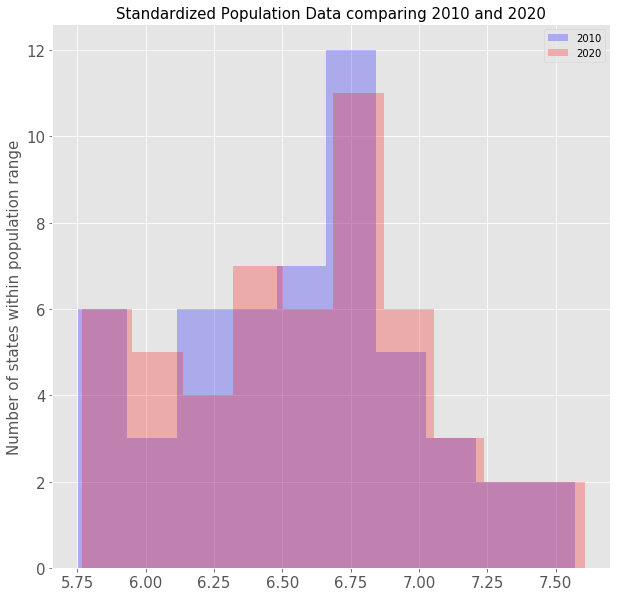

In [20]:
## set the figure dimensions
hist_fig = plt.figure(figsize = (10, 10))
    
## make two histogram that are different colors
_  = plt.hist(np.log10(demo_model['2010'] - np.mean(demo_model['2010']) / np.std(demo_model['2010'])), color = "blue", alpha = 0.25, label = "2010")
_  = plt.hist(np.log10(demo_model['2020'] - np.mean(demo_model['2020']) / np.std(demo_model['2020'])), color = "red", alpha = 0.25, label = "2020")

## Set the tick and label fontsize
plt.tick_params(labelsize = 15)

## Set the title
_ = plt.title("Standardized Population Data comparing 2010 and 2020", fontsize = 15)

## Set the y-label
_ = plt.ylabel("Number of states within population range", fontsize = 15)
_ = plt.legend()

### Demographic Data by State

Using demographics data from the United States Census, predictions were calculated through 2020 for each race group in a state using the previously created linear regression formula, `train_mod`.  Then cosine similarity of the population between 2010 and 2020 were completed to identify any major shifts in demographic breakdowns within each state.

In [21]:
## load demographic data
df = pd.read_csv('./data/State_Demo.csv')
df.head()

,Geo_loc,2010 White,2010 Native Hawaiian and Other Pacific Islander,2010 Asian,2010 American Indian and Alaska Native,2010 Black or African American,2010 Hispanic,2011 White,2011 Native Hawaiian and Other Pacific Islander,2011 Asian,...,2015 Hispanic,2016 White,2016 Native Hawaiian and Other Pacific Islander,2016 Asian,2017 American Indian and Alaska Native,2017 Black or African American,2017 Hispanic,2017 White,2017 Native Hawaiian and Other Pacific Islander,2017 Asian
0,Alabama,3262592,4132,66047,53172,1275265,193365,3264590,4245,68618,...,208039,3264048,5047,82875,56705,1323196,213476,3264132,5230,86055
1,Alaska,498166,10695,49160,134048,30801,45361,500752,11119,50994,...,56195,497802,13100,58896,138590,34451,57563,493807,13482,60211
2,Arizona,3805323,20352,215116,295397,285850,1952303,3817079,20826,223419,...,2158415,3942220,23748,273428,317782,348175,2211331,3976031,24619,284344
3,Arkansas,2219838,7350,44179,43727,465957,192868,2226150,7850,46431,...,220149,2226641,9994,56076,47960,484645,226999,2230512,10531,58286
4,California,15810693,235361,5369731,386159,2453834,14496195,15798597,239650,5497179,...,15601886,15719992,260710,6239876,392456,2536049,15794704,15638899,263704,6388282


#### Processed Demographic Data with 2018-2020 Projections

In [22]:
## reset column name with first layer of year and second layer with race, part1

import re
all_column=df.columns.values
header1=[]
header2=[]
year_list=()
##find and split year from column, header1 is years, header2 is race
for column in all_column:
    year=re.findall('\d{4}',column)
    header1.append(year[0]) if len(year)==1 else None
    header2.append(column[5:]) if len(year)==1 else None
    
year_list=sorted(list(set(header1)))
#     year_list+=(year[0])
header1=np.array(header1)
header2=np.array(header2)
# part 2, to update the columns
new_df=df.copy()
## drop 'Geo_loc' and add back later
new_df=(new_df.drop('Geo_loc',axis=1))
##combine two header to one
header = [header1,header2]

## add header to new_df
new_df.columns=header
## add 'Geo_loc' back to new-df
new_df['Geo_loc']=df['Geo_loc']
## a dict for each race to find year
from collections import defaultdict
dic=defaultdict(list)

for i in new_df.columns:
    dic[i[1]].append(i[0])

    
dic.pop('')
years_for_each_race_dic=dic
for i in years_for_each_race_dic:
    print(i,years_for_each_race_dic[i])
    ## Sum all race, and show eacho year
    
def get_all_race(dataframe):
    all_race_df=pd.DataFrame()
    for year in year_list:
        all_race_df[year]=(np.sum(dataframe[year][dataframe[year].columns.values],axis=1))
    all_race_df.index=dataframe['Geo_loc']  


    return all_race_df

all_race_df=get_all_race(new_df)
## to get one race with all year data
def get_one_race_all_year(dataframe,race):
    result=pd.DataFrame()
    if race in dic:
        for year in dic[race]:
            result[year]=dataframe[year,race]
    result['Geo_loc']=dataframe['Geo_loc']
    result=result.set_index('Geo_loc')

    return result


#average percentage for one race
def percent(dataframe):
    dataframe_t=dataframe.T
    dataarray=dataframe_t.to_numpy()
    dataarray=(dataarray/np.mean(dataarray,axis=0))
    dataarray=np.transpose(dataarray)
    dataframe=pd.DataFrame(dataarray,index = dataframe.index,columns=dataframe.columns)
    return dataframe


##percentage change of sum of all race
def percent_change(dataframe):
    year_list_in_function=dataframe.columns.values
    output_df=pd.DataFrame(index=dataframe.index)
    for i in range(len(year_list_in_function)-1):

        output_df[year_list_in_function[i+1]] = (dataframe[year_list_in_function[i+1]] - dataframe[year_list_in_function[i]]) / dataframe[year_list_in_function[i]] * 100.0

    return output_df
percent_change_sum_race=percent_change(all_race_df)

predicted=train_mod(all_race_df,2020)

from numpy.linalg import norm
def cos_sim(a,b):
    return np.dot(a,b)/(norm(a)*norm(b))

from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine

def predict_all_race(datafarme):
    output=datafarme.copy()
    for race in years_for_each_race_dic:

        temp_df=pd.DataFrame(index = datafarme.index, columns=years_for_each_race_dic[race])
        for year in years_for_each_race_dic[race]:
            temp_df[year]=datafarme[year,race]

        after_predict_single_race=(train_mod(temp_df,2020))    
        for year in after_predict_single_race:
            output[year,race]=after_predict_single_race[year]
    return output
    
# get_all_race(new_df)
all_race_predicted=predict_all_race(new_df)

## sort dataframe by columns name
all_race_predicted = all_race_predicted.sort_index(ascending=[True, False],axis=1)
all_race_predicted=all_race_predicted.set_index('Geo_loc')
all_race_predicted.head(10)

White ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
Native Hawaiian and Other Pacific Islander ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
Asian ['2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']
American Indian and Alaska Native ['2010', '2011', '2012', '2013', '2014', '2015', '2017']
Black or African American ['2010', '2011', '2012', '2013', '2014', '2015', '2017']
Hispanic ['2010', '2011', '2012', '2013', '2014', '2015', '2017']


2010                                             \
                         White Native Hawaiian and Other Pacific Islander   
Geo_loc                                                                     
Alabama                3262592                                       4132   
Alaska                  498166                                      10695   
Arizona                3805323                                      20352   
Arkansas               2219838                                       7350   
California            15810693                                     235361   
Colorado               3628359                                      12167   
Connecticut            2602842                                       3695   
Delaware                602846                                        879   
District of Columbia    220680                                        841   
Florida               11146662                                      31580   

                                                                   \
                      Hispanic Black or African American    Asian   
Geo_loc                                                             
Alabama                 193365                   1275265    66047   
Alaska                   45361                     30801    49160   
Arizona                1952303                    285850   215116   
Arkansas                192868                    465957    44179   
California            14496195                   2453834  5369731   
Colorado               1084753                    227406   176759   
Connecticut             502627                    370127   156017   
Delaware                 76652                    199886    33449   
District of Columbia     59057                    309763    26511   
Florida                4331291                   3024796   554011   

                                                            2011  \
                     American Indian and Alaska Native     White   
Geo_loc                                                            
Alabama                                          53172   3264590   
Alaska                                          134048    500752   
Arizona                                         295397   3817079   
Arkansas                                         43727   2226150   
California                                      386159  15798597   
Colorado                                         64379   3666111   
Connecticut                                      22429   2589675   
Delaware                                          7728    604383   
District of Columbia                              4947    228458   
Florida                                         119638  11180169   

                                                                           \
                     Native Hawaiian and Other Pacific Islander  Hispanic   
Geo_loc                                                                     
Alabama                                                    4245    196845   
Alaska                                                    11119     47638   
Arizona                                                   20826   1984792   
Arkansas                                                   7850    198328   
California                                               239650  14743664   
Colorado                                                  12587   1107408   
Connecticut                                                3776    519209   
Delaware                                                    896     79337   
District of Columbia                                        861     63394   
Florida                                                   32514   4470717   

                                                ...        2019  \
                     Black or African American  ...    Hispanic   
Geo_loc                                         ...               
Alabama                               

In [23]:
def year_similarity(dataframe,a,b):
    temp_df=pd.DataFrame(columns=dataframe.index,index=['2010 vs 2020'])

    temp_a=dataframe[a].transpose()
    temp_b=dataframe[b].transpose()

    for state in temp_a:

        temp_df[state]=cos_sim(temp_a[state],temp_b[state])

    temp_df=temp_df.transpose()


    return temp_df

similarity_2010_2020 = year_similarity(all_race_predicted,'2010','2020')

#### Demographic Dissimilarity between 2010 and 2020

Within each state, the demographic similarity remains high between 2010 and 2020. To better showcase the demographic differences, the cosine similarity value was subtracted from 1 to compute dissimilarity as shown in the plot below. While the District of Columbia, Nevada and New Jersey are leading the way in demographic shifts, a review of the difference on the y-axis shows those differences are at or just below 0.005 or 0.5%.

**Demographic Similarity Sample**

In [24]:
similarity_2010_2020.head(10)

,2010 vs 2020
Geo_loc,
Alabama,0.999775
Alaska,0.998759
Arizona,0.998660
Arkansas,0.999704
California,0.996747
Colorado,0.999771
Connecticut,0.997509
Delaware,0.999008
District of Columbia,0.994756


**Demographic Dissimilarity Sample**

In [25]:
dissimilarity_2010_2020 = 1 - similarity_2010_2020
dissimilarity_2010_2020.head(10)

,2010 vs 2020
Geo_loc,
Alabama,0.000225
Alaska,0.001241
Arizona,0.001340
Arkansas,0.000296
California,0.003253
Colorado,0.000229
Connecticut,0.002491
Delaware,0.000992
District of Columbia,0.005244


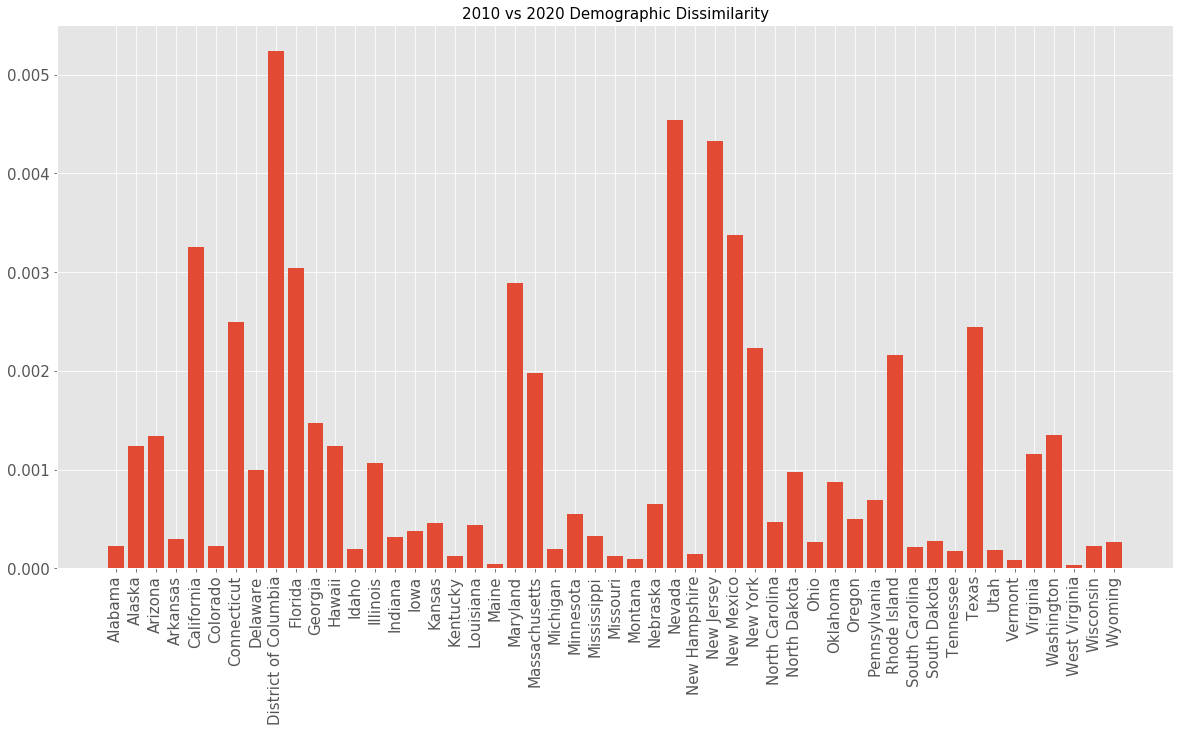

In [26]:
bar_fig = plt.figure(figsize = (20, 10))
        
_  = plt.bar(
    dissimilarity_2010_2020.index.values,
    height = dissimilarity_2010_2020['2010 vs 2020'],
    tick_label = dissimilarity_2010_2020.index.values)
plt.tick_params(labelsize = 15)
_ = plt.title("2010 vs 2020 Demographic Dissimilarity", fontsize = 15)
plt.xticks(rotation=90,fontsize = 15)
plt.show()

### Congressional Apportionment

The most critical concept to this project is apportionment which is the process of assigning the number of representatives each state is alloted in the House of Representatives. Unlike the Senate which allots two seats per state, the House of Representatives is a larger body wherein a state's population at the time of each decennial census drives the number of seats each state is assigned with each state guaranteed a minimum of one (1) representative. Furthermore, these seats are elected based on districts within a given state so in addition to potentially gaining or lossing representatives, each state has the potential to gain or lose districts. The redrawing of congressional district lines is managed at the state level by the political party in power and is generally viewed as a highly partisan process.

Apportionment, however, is strictly math using the method of equal proportions. To begin, each state is assigned one (1) seat, leaving 385 seats to be assigned by population proportion. A priority value $A$ is calculated for each state using the following equation:
$$A_{n} = \frac{P}{\sqrt{n(n+1)}}$$
where $n$ is the number of seats currently assigned to the state and $P$ is the state's population. The state with the highest priority is assigned one additional seat, and their priority, $A$, is recalculated. Once recalculated, the state with the highest priority value is assigned a seat, and their priority value is recalculated. This continues until all 385 available seats are assigned.

Source: https://en.wikipedia.org/wiki/United_States_congressional_apportionment#Apportionment_methods

**Subset of the full Population Dataframe for further investigation**

In [27]:
all_population = demo_model[['State','2010','2020']]
all_population['Population Change'] = all_population['2020'] - all_population['2010']
all_population['Percent Change'] = (all_population['2020'] - all_population['2010']) / all_population['2020'] * 100.0
all_population.head(10)

C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,State,2010,2020,Population Change,Percent Change
0,Alabama,4785579,4912564.0,126985.0,2.584903
1,Alaska,714015,749429.0,35414.0,4.725464
2,Arizona,6407002,7283490.0,876488.0,12.033901
3,Arkansas,2921737,3037790.0,116053.0,3.820310
4,California,37327690,40493766.0,3166076.0,7.818675
5,Colorado,5048029,5854532.0,806503.0,13.775704
6,Connecticut,3580171,3588628.0,8457.0,0.235661
7,Delaware,899712,988853.0,89141.0,9.014586
8,District of Columbia,605040,731466.0,126426.0,17.283920
9,Florida,18846461,21916080.0,3069619.0,14.006241


**Population Subset with District of Columbia and Puerto Rico removed**

In [28]:
ex_list = ['Puerto Rico', 'District of Columbia']  ## exclusion list
state_only_df = all_population[~all_population['State'].isin(ex_list)]  ### taking out DC and PR
state_only_df = state_only_df.reset_index(drop=True)
state_only_df.head(10)  

,State,2010,2020,Population Change,Percent Change
0,Alabama,4785579,4912564.0,126985.0,2.584903
1,Alaska,714015,749429.0,35414.0,4.725464
2,Arizona,6407002,7283490.0,876488.0,12.033901
3,Arkansas,2921737,3037790.0,116053.0,3.820310
4,California,37327690,40493766.0,3166076.0,7.818675
5,Colorado,5048029,5854532.0,806503.0,13.775704
6,Connecticut,3580171,3588628.0,8457.0,0.235661
7,Delaware,899712,988853.0,89141.0,9.014586
8,Florida,18846461,21916080.0,3069619.0,14.006241
9,Georgia,9712696,10739800.0,1027104.0,9.563530


**Addition of one seat per state to establish apportionment baseline**

In [29]:
state_only_df['2020 Apportionment'] = 1  ## assigning each state a seat
state_only_df.head()

,State,2010,2020,Population Change,Percent Change,2020 Apportionment
0,Alabama,4785579,4912564.0,126985.0,2.584903,1
1,Alaska,714015,749429.0,35414.0,4.725464,1
2,Arizona,6407002,7283490.0,876488.0,12.033901,1
3,Arkansas,2921737,3037790.0,116053.0,3.820310,1
4,California,37327690,40493766.0,3166076.0,7.818675,1


**Calculation of state priority value and seat apportionment using three functions**

In [30]:
import math

## Calculate state priority
def priority(df):
    for i, row in df.iterrows():
        seats = row['2020 Apportionment']
        state_pr = int(row['2020'])
        #state_pr = int(state_pr)
       
        n = seats * (seats+1)
        state_pri = math.sqrt(n)
        
        final_pr = state_pr/state_pri        
        df.loc[i,'priority'] = final_pr
        

    return(df)    

fill_list = []

## Add seats based on priority calculation
def seat_assign(df1):
    df2 = priority(df1)
    p = df2.loc[df2['priority'].idxmax()]
    state_that_has_pri = (p[0])
    for i, row in df2.iterrows():
        if row['State'] == state_that_has_pri:
            j = row['2020 Apportionment']
            df2.loc[i,'2020 Apportionment'] = j + 1
            fill_list.append(row['State'])
            #print(row)
    return(df2)

## Apportionment function
def main_app(df, available_seats):
    apportionment = 0
    while apportionment < available_seats:
        apportionment += 1
        new_df_ap_df = seat_assign(df)
    return(new_df_ap_df)  

In [31]:
df_projected_seats = main_app(state_only_df, 385) ### run apportionment

In [32]:
## confirm apportionment assigned correct number of seats
df_projected_seats['2020 Apportionment'].sum()

435

In [33]:
## Review first set of states assigned representatives
pprint(fill_list[:10])

['California',
 'Texas',
 'California',
 'Florida',
 'New York',
 'Texas',
 'California',
 'Pennsylvania',
 'California',
 'Illinois']


In [34]:
## Review last set of states assigned representatives
pprint(fill_list[-10:])

['North Carolina',
 'Colorado',
 'Oregon',
 'Wisconsin',
 'Pennsylvania',
 'Illinois',
 'California',
 'Texas',
 'Florida',
 'Arizona']


In reviewing the fill list, the impact of significant populations is evident since seats are assigned to California up to the very end of seat apportionment.

In [35]:
## merge population and apportionment projection data with current rep data
final_states_dataset = pd.merge(df_projected_seats, pd.read_csv("./data/2010_Apportionment.csv"), how = "inner", left_on ='State', right_on = 'State')

## merge demographic dissimilarity into final dataset
final_states_dataset = pd.merge(final_states_dataset, dissimilarity_2010_2020, how = "inner", left_on='State', right_on = 'Geo_loc')

final_states_dataset['Gain/Loss'] = final_states_dataset['2020 Apportionment'] - final_states_dataset['2010 Apportionment']

final_states_dataset['Gain/Loss %'] = ((final_states_dataset['2020 Apportionment'] - final_states_dataset['2010 Apportionment'])/ final_states_dataset['2010 Apportionment'])*100

final_states_dataset['2010 Citizens per Rep'] = final_states_dataset['2010'] / final_states_dataset['2010 Apportionment']

final_states_dataset['2020 Citizens per Rep'] = final_states_dataset['2020'] / final_states_dataset['2020 Apportionment']

final_states_dataset = final_states_dataset.rename(columns={'2020': 'Projected 2020 Population','2020 Apportionment':'Projected 2020 Apportionment','Gain/Loss %':'Projected Gain/Loss %',
                                    'Gain/Loss':'Projected Gain/Loss','2010 vs 2020':'Demographic Dissimilarity','2010':'2010 Population'})

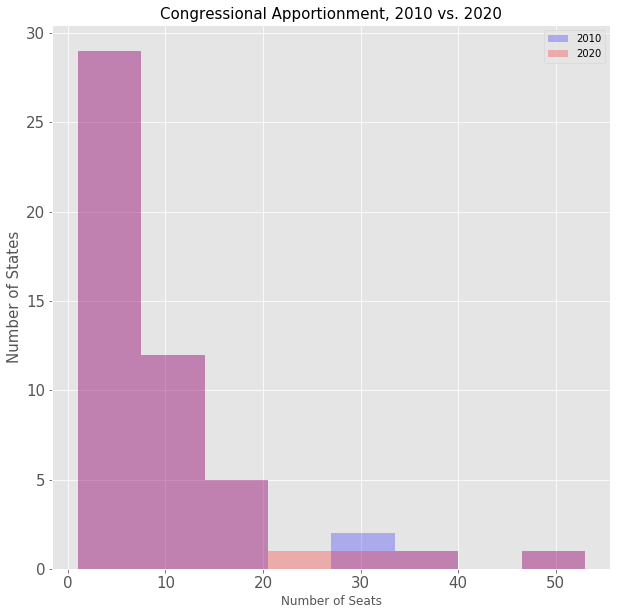

In [36]:
## set the figure dimensions
hist_fig2 = plt.figure(figsize = (10, 10))
    
## make two histogram that ar different colors
_  = plt.hist(final_states_dataset['2010 Apportionment'], bins = 8, color = "blue", alpha = 0.25, label = "2010")
_  = plt.hist(final_states_dataset['Projected 2020 Apportionment'], bins = 8, color = "red", alpha = 0.25, label = "2020")

## Set the tick and label fontsize
plt.tick_params(labelsize = 15)

## Set the title
_ = plt.title("Congressional Apportionment, 2010 vs. 2020", fontsize = 15)

## Set the y-label
_ = plt.xlabel("Number of Seats")
_ = plt.ylabel("Number of States", fontsize = 15)
_ = plt.legend()

#### States Gaining or Losing Seats

In [37]:
states_changes_only = final_states_dataset[final_states_dataset['Projected Gain/Loss'] != 0]
states_changes_only.sort_values('Projected Gain/Loss', ascending = False)

,State,2010 Population,Projected 2020 Population,Population Change,Percent Change,Projected 2020 Apportionment,priority,2010 Apportionment,Demographic Dissimilarity,Projected Gain/Loss,Projected Gain/Loss %,2010 Citizens per Rep,2020 Citizens per Rep
42,Texas,25241648,29639170.0,4397522.0,14.836859,39,750418.856667,36,0.002442,3,8.333333,701156.888889,7.599787e+05
8,Florida,18846461,21916080.0,3069619.0,14.006241,29,743024.699522,27,0.003047,2,7.407407,698017.074074,7.557269e+05
2,Arizona,6407002,7283490.0,876488.0,12.033901,10,767747.257169,9,0.001340,1,11.111111,711889.111111,7.283490e+05
5,Colorado,5048029,5854532.0,806503.0,13.775704,8,689963.212979,7,0.000229,1,14.285714,721147.000000,7.318165e+05
32,North Carolina,9574247,10575011.0,1000764.0,9.463480,14,729745.088077,13,0.000469,1,7.692308,736480.538462,7.553579e+05
36,Oregon,3837073,4277933.0,440860.0,10.305444,6,660099.392813,5,0.000500,1,20.000000,767414.600000,7.129888e+05
0,Alabama,4785579,4912564.0,126985.0,2.584903,6,758025.082103,7,0.000225,-1,-14.285714,683654.142857,8.187607e+05
12,Illinois,12841196,12780601.0,-60595.0,-0.474117,17,730618.329590,18,0.001067,-1,-5.555556,713399.777778,7.518001e+05
21,Michigan,9876731,10000546.0,123815.0,1.238082,13,741289.788874,14,0.000200,-1,-7.142857,705480.785714,7.692728e+05
22,Minnesota,5310711,5691135.0,380424.0,6.684501,7,760509.903996,8,0.000547,-1,-12.500000,663838.875000,8.130193e+05


In sorting by the number of seats gained or lost and inspecting the head and tail, it can be determined that Texas and Florida are expected to pick up multiple seats while states losing seats will only lose one. In total, six (6) states will gain at least one seat while nine (9) states will lose one seat. Of note, the Insights Association, a DC-based market research firm, published <a href = "https://www.insightsassociation.org/article/states-expected-gain-or-lose-congressional-seats-after-2020-census" target = "_blank">an article in August 2018</a> that has the same projections our project has outlined.

#### Congressional Representation by State

Focusing only on those states that will gain or loss congressional seats, a comparison of the average number of citizens represented by a representative in each state in 2010 vs 2020. With the United States population still on the rise and no adjustment to the number for overall House of Representative members, it is expected that the number of citizens in a given stat would continue to increase. Even in gaining three congressional seats, Texas's citizens-to-congress representative will increase by approximately 60,000 between 2010 and 2020.

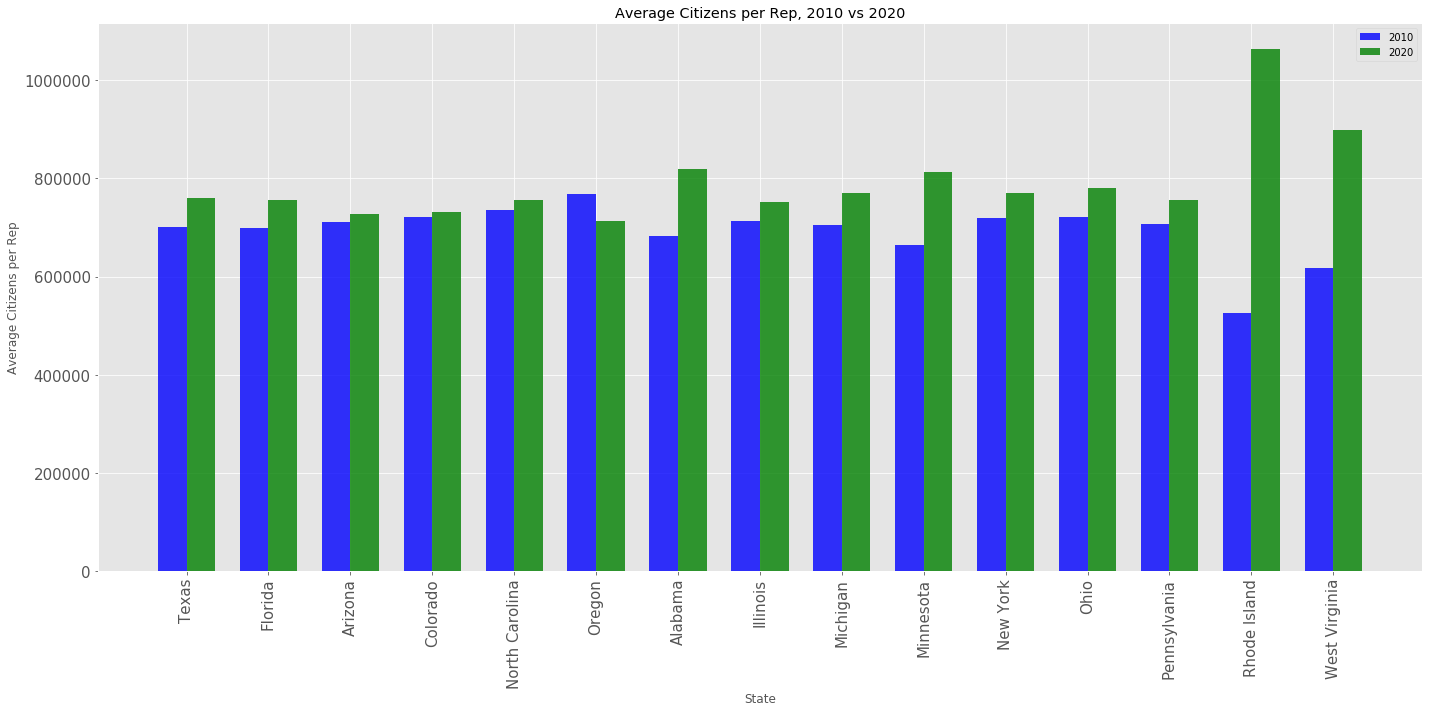

In [38]:
# data to plot
n_groups = 15

rate = states_changes_only[['State','2010 Citizens per Rep','2020 Citizens per Rep', 'Projected Gain/Loss']].sort_values('Projected Gain/Loss', ascending = False)

# create plot
fig, ax = plt.subplots(figsize = (20,10))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, rate['2010 Citizens per Rep'], bar_width, alpha=opacity, color='b', label='2010')
rects2 = plt.bar(index + bar_width, rate['2020 Citizens per Rep'], bar_width, alpha=opacity, color='g', label='2020')
 
plt.xlabel('State')
plt.ylabel('Average Citizens per Rep')
plt.title('Average Citizens per Rep, 2010 vs 2020')
plt.xticks(index + bar_width/2, rate['State'], rotation = 90)
plt.legend()
plt.tick_params(labelsize = 15)
plt.tight_layout()
plt.show()

#### Congressional Apportionment with District of Columbia and Puerto Rico

To further explore the impact of the country's population on the assignment of congressional seats, an analysis of congressional apportionment was completed that included the District of Columbia and Puerto Rico. This model operates under the assumption that each will have attained statehood by the 2020 census. While this is unlikely, this could identify . The overall number of available congressional seats did not change since the number of seats was set at 435 in 1913 and was only temporarily increased to 437 from 1959 - 1962 because Alaska and Hawaii were admitted to the Union until the results of the 1960 census apportionment could go into effect.


**Addition of one seat per state to establish apportionment baseline**

In [39]:
all_population_app = all_population
all_population_app['2020 Apportionment'] = 1  ## assigning each state a seat
all_population_app.head(10)

C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,State,2010,2020,Population Change,Percent Change,2020 Apportionment
0,Alabama,4785579,4912564.0,126985.0,2.584903,1
1,Alaska,714015,749429.0,35414.0,4.725464,1
2,Arizona,6407002,7283490.0,876488.0,12.033901,1
3,Arkansas,2921737,3037790.0,116053.0,3.820310,1
4,California,37327690,40493766.0,3166076.0,7.818675,1
5,Colorado,5048029,5854532.0,806503.0,13.775704,1
6,Connecticut,3580171,3588628.0,8457.0,0.235661,1
7,Delaware,899712,988853.0,89141.0,9.014586,1
8,District of Columbia,605040,731466.0,126426.0,17.283920,1
9,Florida,18846461,21916080.0,3069619.0,14.006241,1


In [40]:
## Adjust the number of remaining seats down to 383 since 52 seats are assigned to each state (+2 for DC and PR)
projected_seats_all = main_app(all_population_app, 383)

C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Loganj2\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [41]:
projected_seats_all.tail(10)

,State,2010,2020,Population Change,Percent Change,2020 Apportionment,priority
42,Tennessee,6355882,6871160.0,515278.0,7.499141,9,724283.858915
43,Texas,25241648,29639170.0,4397522.0,14.836859,38,769913.501937
44,Utah,2775260,3243450.0,468190.0,14.434938,4,725257.468162
45,Vermont,625842,622477.0,-3365.0,-0.540582,1,440157.707833
46,Virginia,8025206,8649712.0,624506.0,7.219963,11,752860.794826
47,Washington,6741386,7686852.0,945466.0,12.299781,10,732912.581107
48,West Virginia,1854315,1798004.0,-56311.0,-3.131862,2,734032.059247
49,Wisconsin,5690403,5838816.0,148413.0,2.541834,8,688111.064617
50,Wyoming,564376,585286.0,20910.0,3.572612,1,413859.699534
51,Puerto Rico,3721525,3170262.0,-551263.0,-17.388563,4,708892.133848


In [42]:
projected_seats_all['2020 Apportionment'].sum()

435

In [43]:
## merge population and apportionment projection data with current rep data
final_all_dataset = pd.merge(projected_seats_all, pd.read_csv("./data/2010_Apportionment.csv"), how = "left", left_on ='State', right_on = 'State')

## fill DC and Puerto Rico 2010 Apportionment with zeroes since they currently have no representation
final_all_dataset['2010 Apportionment'].fillna(0, inplace = True)

## merge demographic dissimilarity into final dataset
final_all_dataset = pd.merge(final_all_dataset, dissimilarity_2010_2020, how = "left", left_on='State', right_on = 'Geo_loc')

final_all_dataset['2010 vs 2020'].fillna(0, inplace = True)

## calculate losses/gains in seats
final_all_dataset['Gain/Loss'] = final_all_dataset['2020 Apportionment'] - final_all_dataset['2010 Apportionment']

final_all_dataset['Projected Gain/Loss %'] = ((final_all_dataset['2020 Apportionment'] - final_all_dataset['2010 Apportionment'])/ final_all_dataset['2010 Apportionment'])*100

final_all_dataset['2010 Citizens per Rep'] = final_all_dataset['2010'] / final_all_dataset['2010 Apportionment']

final_all_dataset['2020 Citizens per Rep'] = final_all_dataset['2020'] / final_all_dataset['2020 Apportionment']

final_all_dataset['2010 Citizens per Rep'].replace(np.inf, 0, inplace = True)

final_all_dataset = final_all_dataset.rename(columns={'2020': 'Projected 2020 Population','2020 Apportionment':'Projected 2020 Apportionment',
                                    'Gain/Loss':'Projected Gain/Loss','2010 vs 2020':'Demographic Dissimilarity','2010':'2010 Population'})

In [44]:
all_changes_only = final_all_dataset[final_all_dataset['Projected Gain/Loss'] != 0]
all_changes_only.shape[0]

17

#### States Gaining or Losing Seats

In [45]:
all_changes_only.sort_values('Projected Gain/Loss', ascending = False)

,State,2010 Population,Projected 2020 Population,Population Change,Percent Change,Projected 2020 Apportionment,priority,2010 Apportionment,Demographic Dissimilarity,Projected Gain/Loss,Projected Gain/Loss %,2010 Citizens per Rep,2020 Citizens per Rep
51,Puerto Rico,3721525,3170262.0,-551263.0,-17.388563,4,708892.133848,0.0,0.000000,4.0,inf,0.000000,7.925655e+05
43,Texas,25241648,29639170.0,4397522.0,14.836859,38,769913.501937,36.0,0.002442,2.0,5.555556,701156.888889,7.799782e+05
37,Oregon,3837073,4277933.0,440860.0,10.305444,6,660099.392813,5.0,0.000500,1.0,20.000000,767414.600000,7.129888e+05
5,Colorado,5048029,5854532.0,806503.0,13.775704,8,689963.212979,7.0,0.000229,1.0,14.285714,721147.000000,7.318165e+05
8,District of Columbia,605040,731466.0,126426.0,17.283920,1,517224.568807,0.0,0.005244,1.0,inf,0.000000,7.314660e+05
9,Florida,18846461,21916080.0,3069619.0,14.006241,28,769103.632321,27.0,0.003047,1.0,3.703704,698017.074074,7.827171e+05
33,North Carolina,9574247,10575011.0,1000764.0,9.463480,14,729745.088077,13.0,0.000469,1.0,7.692308,736480.538462,7.553579e+05
48,West Virginia,1854315,1798004.0,-56311.0,-3.131862,2,734032.059247,3.0,0.000038,-1.0,-33.333333,618105.000000,8.990020e+05
39,Rhode Island,1053169,1062521.0,9352.0,0.880171,1,751315.804253,2.0,0.002166,-1.0,-50.000000,526584.500000,1.062521e+06
38,Pennsylvania,12711063,12837233.0,126170.0,0.982844,17,778371.582348,18.0,0.000688,-1.0,-5.555556,706170.166667,7.551314e+05


The dataframe above depicts the hypothetical gains/losses for congressional apportionment following the 2020 census where District of Columbia and Puerto Rico have statehood. A total of 17 states would experience losses or gains in representation in this scenario. Most notably, Puerto Rico would be awarded four seats which is a considerable number of seats. In total, seven (7) states would gain one or more seats following the 2020 census while ten (10) states would lose at least one (1) seat. In comparing these results to the calculations that excluded District of Columbia and Puerto Rico, it should be noted that Illinois is hit hardest, losing one additional seat than previously predicted.

**Congressional Representation by State** <br />
With the new apportionment data set, the graph depicting the average number of citizens each state's representative are accountable to was also redrawn. With an initial assignment of 4 seats, Puerto Rico is similarly positioned at just under 800k citizens per representative. As with the prior visualization, West Virginia and Rhode Island see some of the biggest spikes in representative responsibility due to their loss of seats (West Virginia from 3 to 2, Rhode Island from 2 to 1).

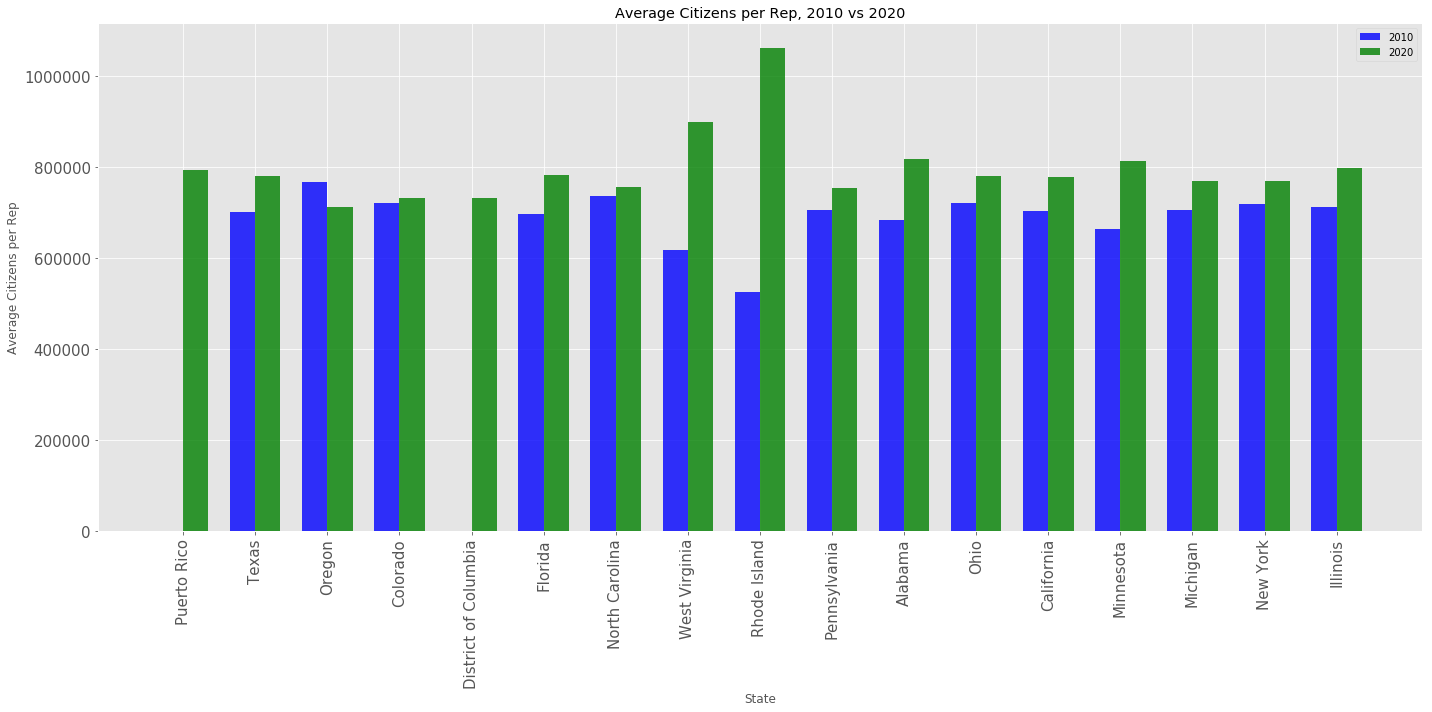

In [46]:
# data to plot
n_groups = 17

rate = all_changes_only[['State','2010 Citizens per Rep','2020 Citizens per Rep', 'Projected Gain/Loss']].sort_values('Projected Gain/Loss', ascending = False)

# create plot
fig, ax = plt.subplots(figsize = (20,10))
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, rate['2010 Citizens per Rep'], bar_width, alpha=opacity, color='b', label='2010')
rects2 = plt.bar(index + bar_width, rate['2020 Citizens per Rep'], bar_width, alpha=opacity, color='g', label='2020')
 
plt.xlabel('State')
plt.ylabel('Average Citizens per Rep')
plt.title('Average Citizens per Rep, 2010 vs 2020')
plt.xticks(index + bar_width/2, rate['State'], rotation = 90)
plt.legend()
plt.tick_params(labelsize = 15)
plt.tight_layout()
plt.show()

#### Final Export of Full Data Set for Import Into Tableau

In [47]:
### Exporting to CSV 
import csv
final_states_dataset.to_csv('./data/output/DSCI521_FinalResults_States.csv', sep='\t',encoding= 'utf-8')
final_all_dataset.to_csv('./data/output/DSCI521_FinalResults_All.csv', sep='\t',encoding= 'utf-8')

In [48]:
### Exporting to Excel spreadsheet
from pandas import ExcelWriter

writer = ExcelWriter('./data/output/DSCI521-FinalResults.xlsx')
final_states_dataset.to_excel(writer,'DSCI521-FinalResults_States')
final_all_dataset.to_excel(writer,'DSCI521-FinalResults_All')
writer.save()

#### Visualization

Using the exported data, Tableau map visualizations were used to create a more accessible, engaging format for data review and intake. The maps feature the major calculated data points for each state which can be accessed simply by rolling over the state.

<a href = "https://public.tableau.com/profile/joey.logan#!/vizhome/Statesfinal/Sheet2?publish=yes" target="_blank">Map of Congressional Seat Gains and Losses for States</a><br />
<a href = "https://public.tableau.com/profile/joey.logan#!/vizhome/StatesfinalwithD_C_andPuertoRico/Sheet2?publish=yes" target="_blank">Map of Congressional Seat Gains and Losses for States, including the District of Columbia and Puerto Rico</a><br />
<a href = "https://public.tableau.com/profile/joey.logan#!/vizhome/DemographicDissimilatory/Sheet2?publish=yes" target="_blank">Map of State Population Dissimilarity between 2010 and 2020</a>